In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/formula-1-world-championship-1950-2020/races.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv
/kaggle/input/formula-1-world-championship-1950-2020/lap_times.csv
/kaggle/input/formula-1-world-championship-1950-2020/status.csv
/kaggle/input/formula-1-world-championship-1950-2020/driver_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/seasons.csv
/kaggle/input/formula-1-world-championship-1950-2020/pit_stops.csv
/kaggle/input/formula-1-world-championship-1950-2020/sprint_results.csv
/kaggle/input/formula-1-world-championship-1950-2020/constructor_standings.csv
/kaggle/input/formula-1-world-championship-1950-2020/results.csv
/kaggle/input/formula-1-world-championship-1950-2020/circuits.csv
/kaggle/input/formula-1-world-championship-1950-2020/qualifying.csv


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import difflib
import warnings
warnings.simplefilter("ignore")

In [3]:
# Many placeholder values use '\N', will need to replace this in data cleaning
races = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/races.csv', na_values='\\N')
results = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/results.csv', na_values='\\N')
drivers = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/drivers.csv', na_values='\\N')
constructors = pd.read_csv('/kaggle/input/formula-1-world-championship-1950-2020/constructors.csv', na_values='\\N')


In [4]:
# Basic information about the datasets
print("Races dataset shape:", races.shape)
print("\nRaces dataset columns:", races.columns.tolist())


Races dataset shape: (1125, 18)

Races dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']


In [5]:
print("\nResults dataset shape:", results.shape)
print("\nResults dataset columns:", results.columns.tolist())


Results dataset shape: (26519, 18)

Results dataset columns: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId']


In [6]:
print("Races dataset shape:", drivers.shape)
print("\nRaces dataset columns:", drivers.columns.tolist())


Races dataset shape: (859, 9)

Races dataset columns: ['driverId', 'driverRef', 'number', 'code', 'forename', 'surname', 'dob', 'nationality', 'url']


In [7]:
print("Constructors dataset shape:", constructors.shape)
print("\nConstructors dataset columns:", constructors.columns.tolist())

Constructors dataset shape: (212, 5)

Constructors dataset columns: ['constructorId', 'constructorRef', 'name', 'nationality', 'url']


In [8]:
# Merge relevant tables
race_results = pd.merge(races, results, on='raceId')
race_results = pd.merge(race_results, drivers, on='driverId')
race_results = pd.merge(race_results, constructors, on='constructorId')

# Show the merged dataset
print("\nMerged dataset shape:", race_results.shape)
print("\nMerged dataset columns:", race_results.columns.tolist())



Merged dataset shape: (26519, 47)

Merged dataset columns: ['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x', 'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code', 'forename', 'surname', 'dob', 'nationality_x', 'url_y', 'constructorRef', 'name_y', 'nationality_y', 'url']


In [9]:
# Create target variable using position order. This will be a binary that will say if someone is on the podium or not
race_results['podium_finish'] = (race_results['positionOrder'] <= 3).astype(int)

# Create full name for drivers
race_results['driver_name'] = race_results['forename'] + ' ' + race_results['surname']

In [10]:
# These are the only columns we need, and there's more unwanted columns so we won't drop, just update the df
relevant_columns = [
                    'raceId', 'year', 'round', 'circuitId', 'grid', 'position',
                    'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name',
                    'constructorId', 'podium_finish'
                   ]

race_results = race_results[relevant_columns]
race_results.head()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,1,2009,1,1,2,2.0,8.0,58,214.344,22,Rubens Barrichello,23,1
2,1,2009,1,1,20,3.0,6.0,58,214.706,15,Jarno Trulli,7,1
3,1,2009,1,1,19,4.0,5.0,58,215.920,10,Timo Glock,7,0
4,1,2009,1,1,10,5.0,4.0,58,215.199,4,Fernando Alonso,4,0


In [11]:
race_results.tail()

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26514,1132,2024,12,9,18,16.0,0.0,50,233.371,839,Esteban Ocon,214,0
26515,1132,2024,12,9,0,17.0,0.0,50,236.409,815,Sergio Pérez,9,0
26516,1132,2024,12,9,14,18.0,0.0,50,233.014,855,Guanyu Zhou,15,0
26517,1132,2024,12,9,1,NaN,0.0,33,232.289,847,George Russell,131,0
26518,1132,2024,12,9,19,NaN,0.0,0,NaN,842,Pierre Gasly,214,0


In [12]:
# Handle missing values. The dataset originally had \N as a placeholder, so we need to keep that in mind
print(race_results.isnull().sum())

raceId                 0
year                   0
round                  0
circuitId              0
grid                   0
position           10928
points                 0
laps                   0
fastestLapSpeed    18499
driverId               0
driver_name            0
constructorId          0
podium_finish          0
dtype: int64


In [13]:
# For numerical columns, fill NAs with 0
numerical_columns = race_results.select_dtypes(include=[np.number]).columns
race_results[numerical_columns] = race_results[numerical_columns].fillna(0)

# For categorical columns, fill NAs with Unknown
categorical_columns = race_results.select_dtypes(include=['object']).columns
race_results[categorical_columns] = race_results[categorical_columns].fillna('Unknown')


In [14]:
# Check missing values after handling
print("\nMissing values after handling:")
print(race_results.isnull().sum())


Missing values after handling:
raceId             0
year               0
round              0
circuitId          0
grid               0
position           0
points             0
laps               0
fastestLapSpeed    0
driverId           0
driver_name        0
constructorId      0
podium_finish      0
dtype: int64


In [15]:
# Remove duplicates if any
duplicates_count = race_results.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates_count}")
race_results = race_results.drop_duplicates()



Number of duplicate rows: 0


In [16]:
# Display basic information about the cleaned dataset
print("\nCleaned dataset info:")
print(race_results.info())


Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26519 entries, 0 to 26518
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           26519 non-null  int64  
 1   year             26519 non-null  int64  
 2   round            26519 non-null  int64  
 3   circuitId        26519 non-null  int64  
 4   grid             26519 non-null  int64  
 5   position         26519 non-null  float64
 6   points           26519 non-null  float64
 7   laps             26519 non-null  int64  
 8   fastestLapSpeed  26519 non-null  float64
 9   driverId         26519 non-null  int64  
 10  driver_name      26519 non-null  object 
 11  constructorId    26519 non-null  int64  
 12  podium_finish    26519 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 2.6+ MB
None


In [17]:
race_results.head(10)

,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
0,1,2009,1,1,1,1.0,10.0,58,216.891,18,Jenson Button,23,1
1,1,2009,1,1,2,2.0,8.0,58,214.344,22,Rubens Barrichello,23,1
2,1,2009,1,1,20,3.0,6.0,58,214.706,15,Jarno Trulli,7,1
3,1,2009,1,1,19,4.0,5.0,58,215.920,10,Timo Glock,7,0
4,1,2009,1,1,10,5.0,4.0,58,215.199,4,Fernando Alonso,4,0
5,1,2009,1,1,5,6.0,3.0,58,217.668,3,Nico Rosberg,3,0
6,1,2009,1,1,13,7.0,2.0,58,213.950,67,Sébastien Buemi,5,0
7,1,2009,1,1,17,8.0,1.0,58,212.537,7,Sébastien Bourdais,5,0
8,1,2009,1,1,16,9.0,0.0,58,214.640,16,Adrian Sutil,10,0
9,1,2009,1,1,9,10.0,0.0,58,216.245,2,Nick Heidfeld,2,0


In [18]:
race_results.tail(10)


,raceId,year,round,circuitId,grid,position,points,laps,fastestLapSpeed,driverId,driver_name,constructorId,podium_finish
26509,1132,2024,12,9,12,11.0,0.0,52,235.713,858,Logan Sargeant,3,0
26510,1132,2024,12,9,17,12.0,0.0,52,235.396,825,Kevin Magnussen,210,0
26511,1132,2024,12,9,15,13.0,0.0,51,233.731,817,Daniel Ricciardo,215,0
26512,1132,2024,12,9,11,14.0,0.0,51,236.301,844,Charles Leclerc,6,0
26513,1132,2024,12,9,16,15.0,0.0,51,232.343,822,Valtteri Bottas,15,0
26514,1132,2024,12,9,18,16.0,0.0,50,233.371,839,Esteban Ocon,214,0
26515,1132,2024,12,9,0,17.0,0.0,50,236.409,815,Sergio Pérez,9,0
26516,1132,2024,12,9,14,18.0,0.0,50,233.014,855,Guanyu Zhou,15,0
26517,1132,2024,12,9,1,0.0,0.0,33,232.289,847,George Russell,131,0
26518,1132,2024,12,9,19,0.0,0.0,0,0.000,842,Pierre Gasly,214,0


In [19]:
# Display final shape and columns of the cleaned df
print("\nFinal shape of the cleaned dataset:", race_results.shape)
print("\nColumns in the cleaned dataset:")
print(race_results.columns.tolist())


Final shape of the cleaned dataset: (26519, 13)

Columns in the cleaned dataset:
['raceId', 'year', 'round', 'circuitId', 'grid', 'position', 'points', 'laps', 'fastestLapSpeed', 'driverId', 'driver_name', 'constructorId', 'podium_finish']


In [20]:
# Descriptive statistics
print(race_results.describe())

             raceId          year         round     circuitId          grid  \
count  26519.000000  26519.000000  26519.000000  26519.000000  26519.000000   
mean     546.376560   1991.099287      8.420793     23.684943     11.145820   
std      309.642244     19.799290      4.992080     18.973790      7.213453   
min        1.000000   1950.000000      1.000000      1.000000      0.000000   
25%      298.000000   1977.000000      4.000000      9.000000      5.000000   
50%      527.000000   1991.000000      8.000000     18.000000     11.000000   
75%      803.000000   2008.000000     12.000000     34.000000     17.000000   
max     1132.000000   2024.000000     22.000000     80.000000     34.000000   

           position        points          laps  fastestLapSpeed  \
count  26519.000000  26519.000000  26519.000000     26519.000000   
mean       4.703194      1.959578     46.228251        61.671736   
std        5.406225      4.306475     29.577860        94.399369   
min        0.000

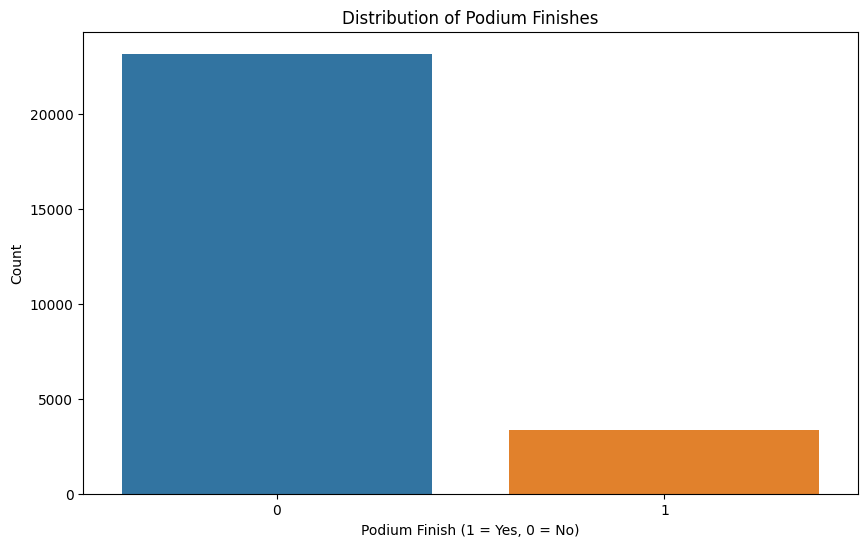

In [21]:
# Distribution of podium finishes
plt.figure(figsize=(10, 6))
sns.countplot(x='podium_finish', data=race_results)
plt.title('Distribution of Podium Finishes')
plt.xlabel('Podium Finish (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

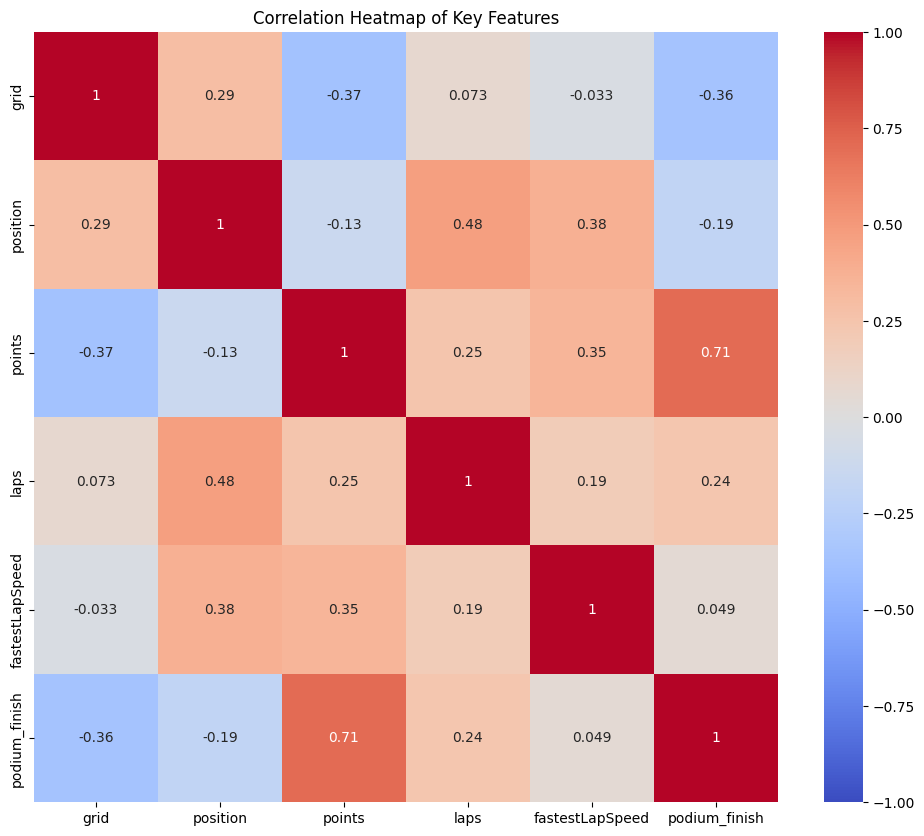

In [22]:
race_results_cleaned = race_results.copy()

heatmap_columns = ['grid', 'position', 'points',
                   'laps', 'fastestLapSpeed', 'podium_finish']
# Replace '\\N' with NaN and convert columns to numeric
for column in heatmap_columns:
    # Replace '\\N' with NaN
    race_results_cleaned[column] = race_results_cleaned[column].replace('\\N', np.nan)
    # Convert the column to numeric, errors='coerce' will handle any remaining non-numeric values
    race_results_cleaned[column] = pd.to_numeric(race_results_cleaned[column], errors='coerce')


# Create correlation matrix
corr = race_results_cleaned[heatmap_columns].corr()

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Features')
plt.show()

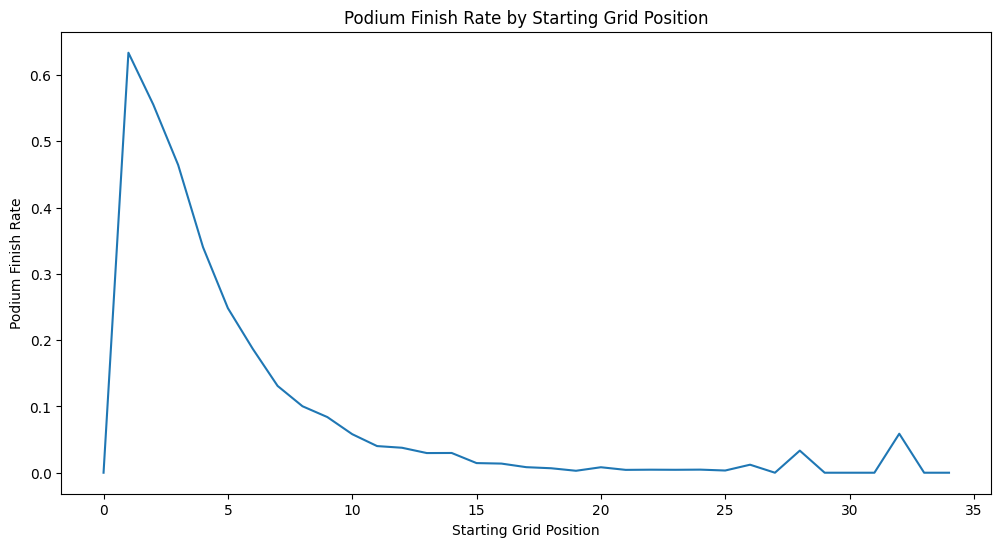

In [23]:
# Podium finish rate by starting position
podium_rate = race_results.groupby('grid')['podium_finish'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=podium_rate.index, y=podium_rate.values)
plt.title('Podium Finish Rate by Starting Grid Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Podium Finish Rate')
plt.show()

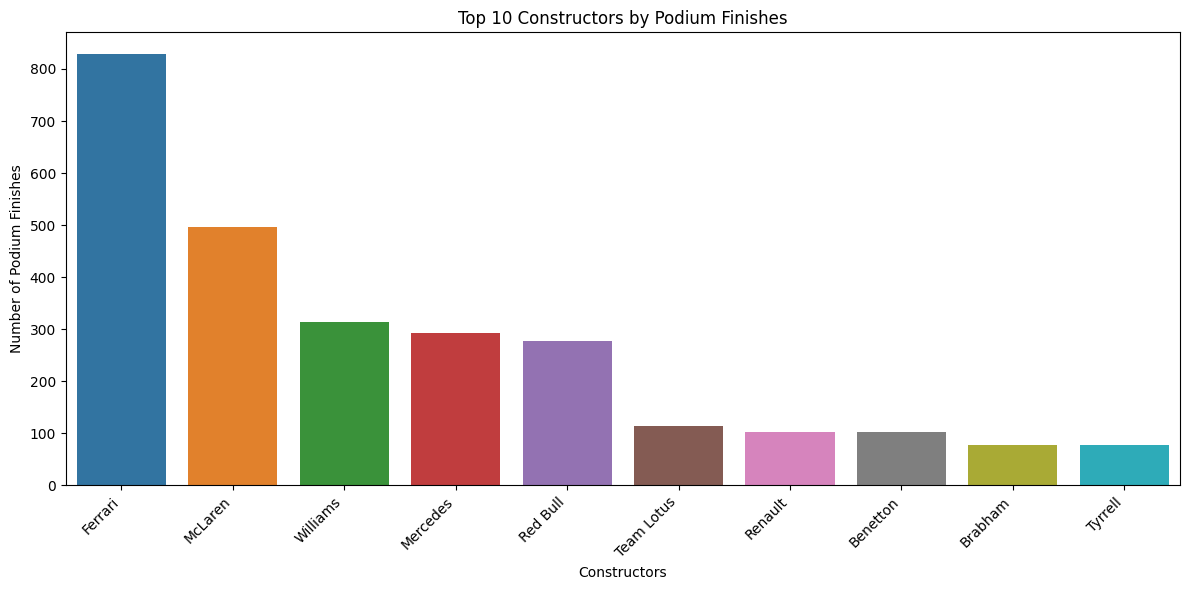

In [24]:
# top constructors
top_constructors = race_results.groupby('constructorId')['podium_finish'].sum().sort_values(ascending=False).head(10)
top_constructors = top_constructors.reset_index()
top_constructors = pd.merge(top_constructors, constructors[['constructorId', 'name']], on='constructorId')

# Bar plot for constructors and their podium finishes
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='podium_finish', data=top_constructors)
plt.title('Top 10 Constructors by Podium Finishes')
plt.xlabel('Constructors')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


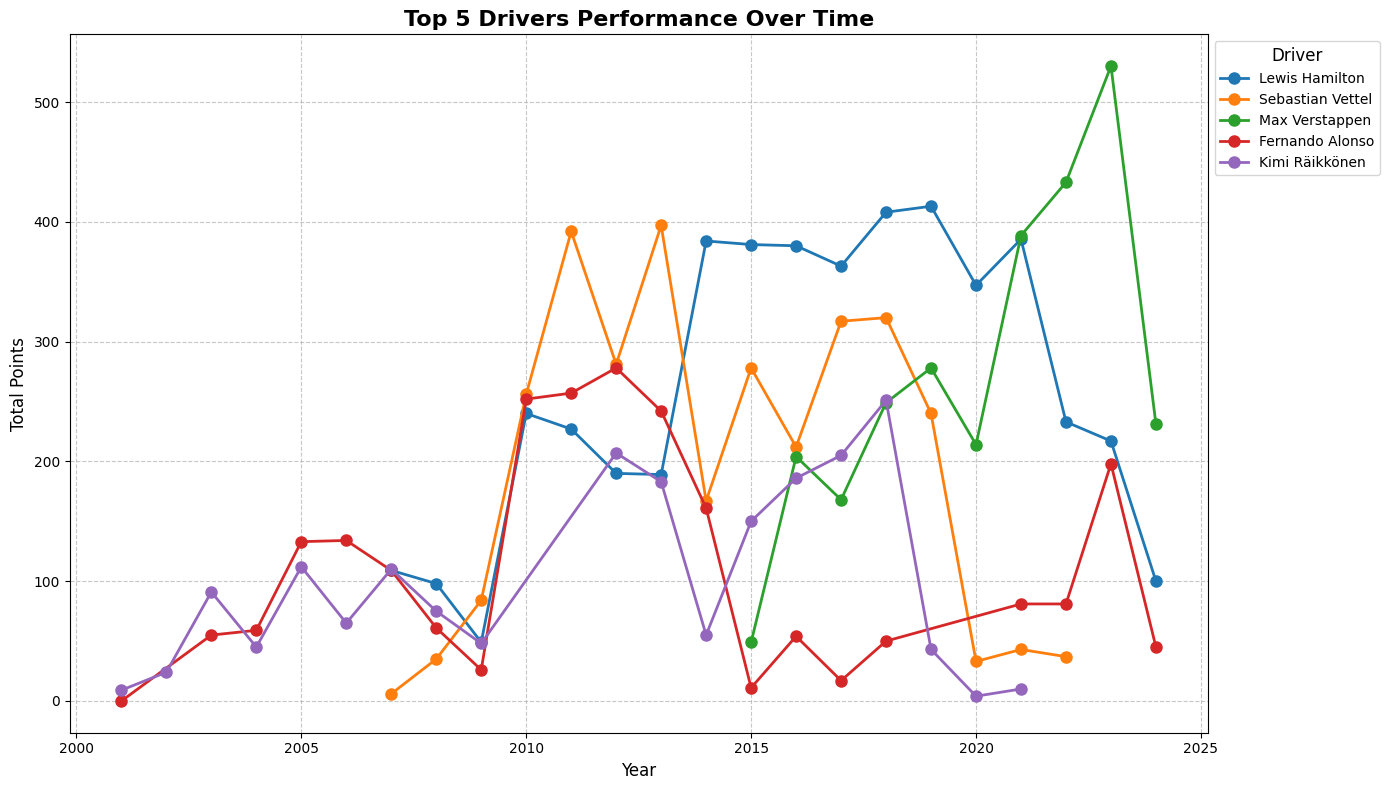

In [25]:
# Get top 5 drivers by total points
top_drivers = race_results.groupby('driver_name')['points'].sum().nlargest(5).index

# Filter data for top drivers
top_drivers_data = race_results[race_results['driver_name'].isin(top_drivers)]

# Create line plot
plt.figure(figsize=(14, 8))
for driver in top_drivers:
    driver_data = top_drivers_data[top_drivers_data['driver_name'] == driver]
    yearly_points = driver_data.groupby('year')['points'].sum()
    plt.plot(yearly_points.index, yearly_points.values, marker='o', linewidth=2, markersize=8, label=driver)

plt.title('Top 5 Drivers Performance Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Points', fontsize=12)
plt.legend(title='Driver', title_fontsize='12', fontsize='10', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

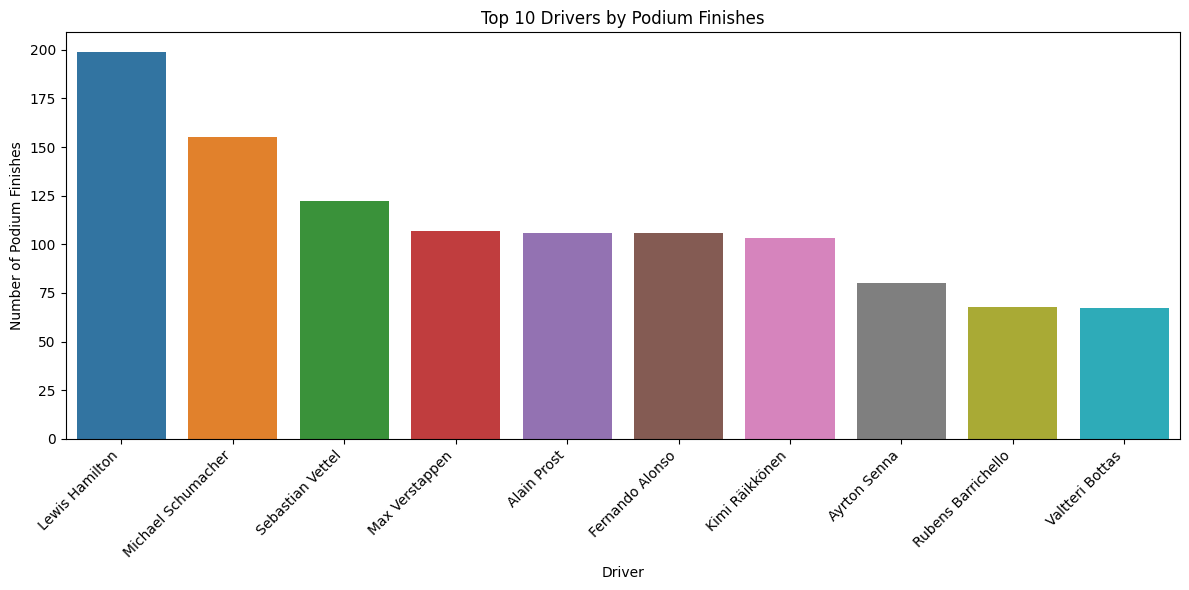

In [26]:
# Top 10 drivers by podium finishes
top_drivers = race_results.groupby('driver_name')['podium_finish'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_drivers.index, y=top_drivers.values)
plt.title('Top 10 Drivers by Podium Finishes')
plt.xlabel('Driver')
plt.ylabel('Number of Podium Finishes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

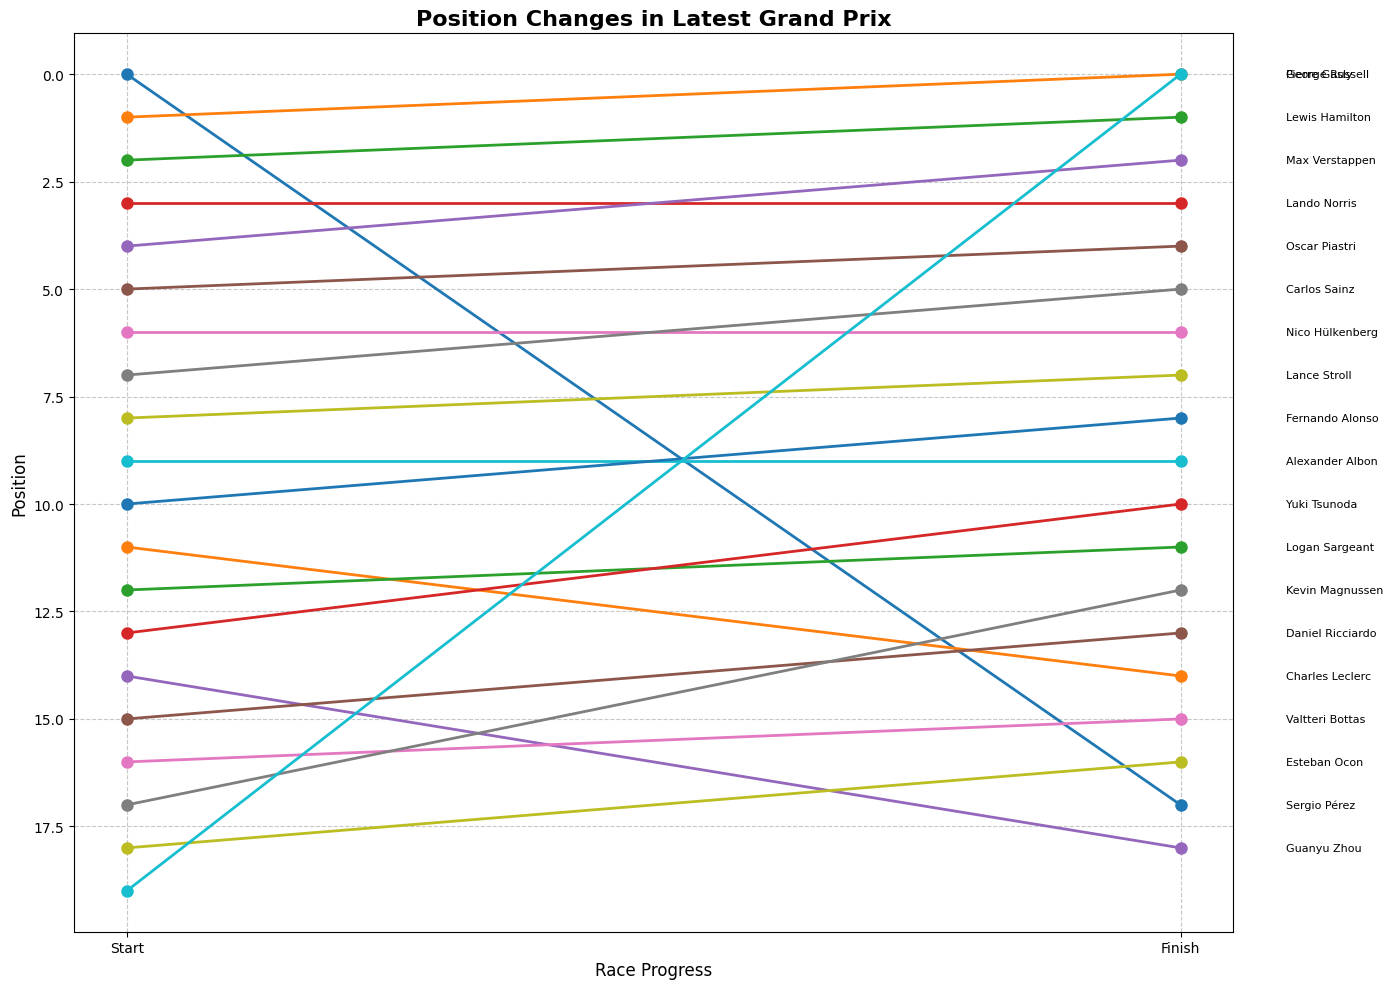

In [27]:
# Sample race grid position and ending position
latest_race = race_results['raceId'].max()
race_data = race_results[race_results['raceId'] == latest_race].sort_values('grid')

plt.figure(figsize=(14, 10))
for _, driver in race_data.iterrows():
    plt.plot([1, 2], [driver['grid'], driver['position']], '-o', linewidth=2, markersize=8)
    plt.text(2.1, driver['position'], driver['driver_name'], fontsize=8, verticalalignment='center')

plt.title(f'Position Changes in Latest Grand Prix', fontsize=16, fontweight='bold')
plt.xlabel('Race Progress', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis so that 1st position is at the top
plt.xticks([1, 2], ['Start', 'Finish'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
# Select features and target
features = ['grid', 'round','fastestLapSpeed']
X = race_results_cleaned[features]
y = race_results_cleaned['podium_finish']

In [29]:
# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [30]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [31]:
# Display information about the preprocessed data
print("Features used:", features)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Features used: ['grid', 'round', 'fastestLapSpeed']
Shape of X_train: (21215, 3)
Shape of X_test: (5304, 3)
Shape of X_train_scaled: (21215, 3)
Shape of X_test_scaled: (5304, 3)


In [32]:
# Display the first few rows of the scaled training data
print("\nFirst few rows of scaled training data:")
print(X_train_scaled.head())


First few rows of scaled training data:
       grid     round  fastestLapSpeed
0 -0.996446 -0.885373        -0.652763
1 -1.551962 -0.685047        -0.652763
2 -0.163172 -0.084068         1.711924
3 -0.440930 -0.685047        -0.652763
4 -0.718688 -0.284394        -0.652763


In [33]:
# Check for any remaining NaN or infinite values
print("\nColumns with NaN values in X_train_scaled:")
print(X_train_scaled.isna().sum()[X_train_scaled.isna().sum() > 0])
print("\nColumns with infinite values in X_train_scaled:")
print(np.isinf(X_train_scaled).sum()[np.isinf(X_train_scaled).sum() > 0])


Columns with NaN values in X_train_scaled:
Series([], dtype: int64)

Columns with infinite values in X_train_scaled:
Series([], dtype: int64)


In [37]:
### Random Forest

rf_model = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print("\nBest Random Forest parameters:", grid_search_rf.best_params_)
rf_best = grid_search_rf.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)


Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [38]:
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred)*100, "%")
print(classification_report(y_test, rf_pred))



Random Forest Results:
Accuracy: 88.63122171945702 %
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4628
           1       0.60      0.32      0.42       676

    accuracy                           0.89      5304
   macro avg       0.75      0.65      0.68      5304
weighted avg       0.87      0.89      0.87      5304



In [39]:
### Logistic Regression with Hyperparameter Tuning

param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train_scaled, y_train)

print("\nBest Logistic Regression parameters:", grid_search_lr.best_params_)
lr_best = grid_search_lr.best_estimator_
lr_tuned_pred = lr_best.predict(X_test_scaled)


print("\nTuned Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, lr_tuned_pred)*100, "%")
print(classification_report(y_test, lr_tuned_pred))


Best Logistic Regression parameters: {'C': 10, 'penalty': 'l1'}

Tuned Logistic Regression Results:
Accuracy: 87.0475113122172 %
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4628
           1       0.08      0.00      0.00       676

    accuracy                           0.87      5304
   macro avg       0.47      0.50      0.47      5304
weighted avg       0.77      0.87      0.81      5304



In [40]:
# Model Evaluation
# Make predictions on test set
lr_pred = lr_model.predict(X_test_scaled)
knn_pred = knn_best.predict(X_test_scaled)
rf_pred = rf_best.predict(X_test_scaled)
lr_tuned_pred = lr_best.predict(X_test_scaled)

# Calculate evaluation metrics
models = {
    'Logistic Regression': lr_model,
    'KNN': knn_best,
    'Random Forest': rf_best,
    'Tuned Logistic Regression': lr_best
}

for name, model in models.items():
    print(f"\n{name} Accuracy: {model.score(X_test_scaled, y_test)}")



Logistic Regression Accuracy: 0.8702865761689291

KNN Accuracy: 0.8778280542986425

Random Forest Accuracy: 0.8863122171945701

Tuned Logistic Regression Accuracy: 0.870475113122172


In [41]:
for name, model in models.items():
    print(f"\n{name} Evaluation:")
    print(classification_report(y_test, model.predict(X_test_scaled)))


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4628
           1       0.00      0.00      0.00       676

    accuracy                           0.87      5304
   macro avg       0.44      0.50      0.47      5304
weighted avg       0.76      0.87      0.81      5304


KNN Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4628
           1       0.53      0.36      0.43       676

    accuracy                           0.88      5304
   macro avg       0.72      0.66      0.68      5304
weighted avg       0.86      0.88      0.87      5304


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4628
           1       0.60      0.32      0.42       676

    accuracy                           0.89      5304
   macro avg       0.75      0.65      0.68      53

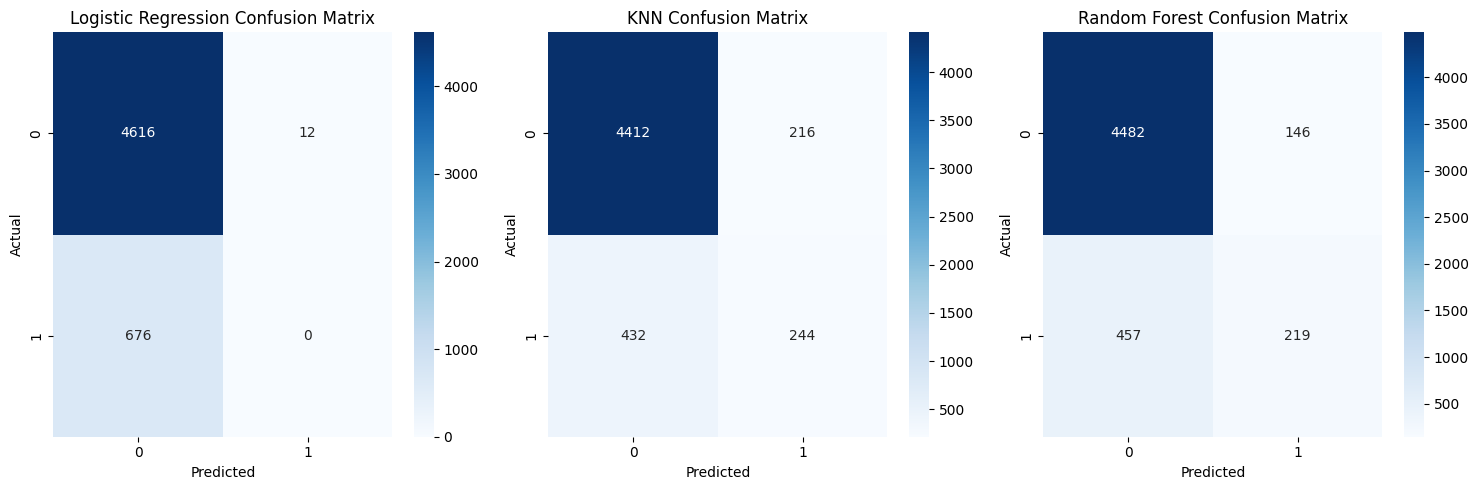

In [42]:
# Select only three models
selected_models = dict(list(models.items())[:3])  

# Confusion Matrix
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(selected_models.items()):
    plt.subplot(1, 3, i+1)
    cm = confusion_matrix(y_test, model.predict(X_test_scaled))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

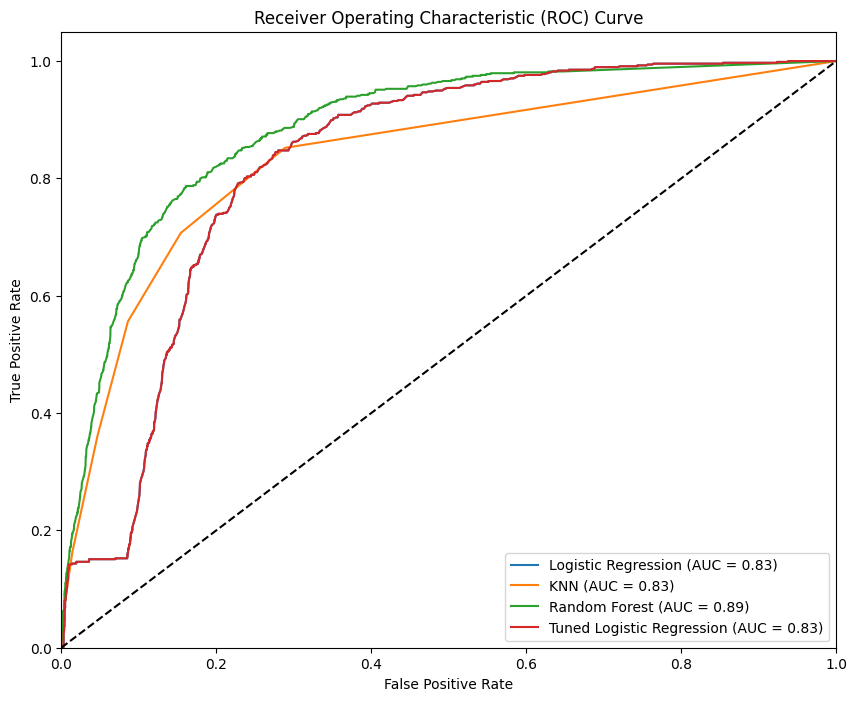

In [43]:
# ROC Curve and AUC
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

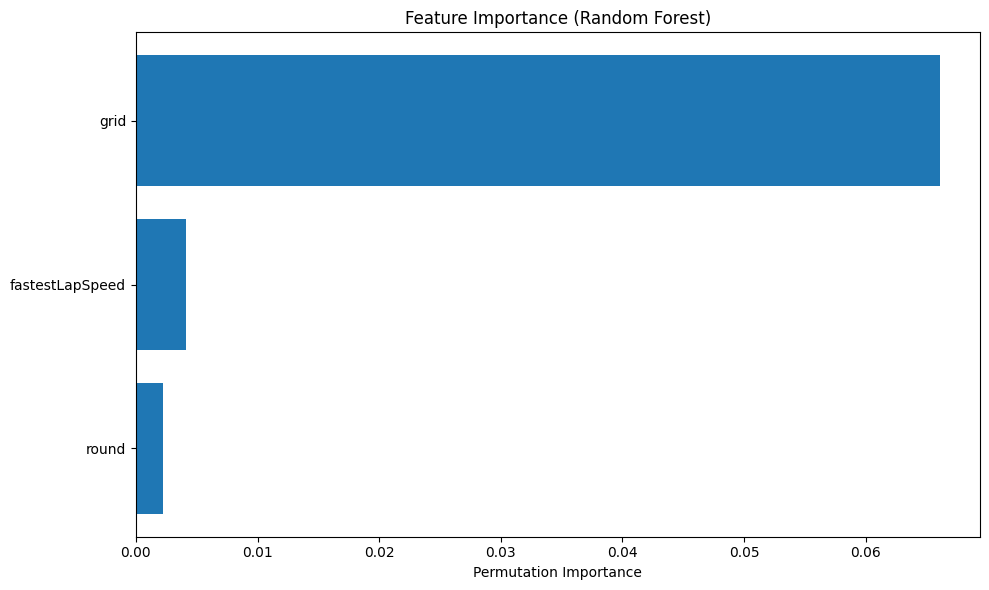

In [44]:
# Feature importance
plt.figure(figsize=(10, 6))
feature_importance = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = feature_importance.importances_mean.argsort()
plt.barh(range(X_test_scaled.shape[1]), feature_importance.importances_mean[sorted_idx])
plt.yticks(range(X_test_scaled.shape[1]), X_test_scaled.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()